In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image

import pathlib
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!ls ../input/plantseedlingslarge/plant-seedlings-large

train-large  train-large-seg


In [4]:
data_dir = '../input/plantseedlingslarge/plant-seedlings-large'
train_dir = os.path.join(data_dir, 'train-large')
# train_dir = os.path.join(data_dir, 'train-large-seg')


In [5]:
train_dir = pathlib.Path(train_dir)
image_count = len(list(train_dir.glob('*/*.png')))
print(image_count)

12000


In [6]:
batch_size = 32
img_height = 300
img_width = 300

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              seed = 7,
                                                              image_size = (img_height, img_width),
                                                              batch_size = batch_size)

'''val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                            validation_split = 0.2,
                                                            subset = "validation",
                                                            seed = 7,
                                                            image_size = (img_height, img_width),
                                                            batch_size = batch_size)'''

Found 12000 files belonging to 12 classes.


2022-03-18 05:50:46.971991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 05:50:47.186342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 05:50:47.187105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 05:50:47.190571: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

'val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,\n                                                            validation_split = 0.2,\n                                                            subset = "validation",\n                                                            seed = 7,\n                                                            image_size = (img_height, img_width),\n                                                            batch_size = batch_size)'

In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)
#print(type(class_names))

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
12


2022-03-18 05:50:49.658523: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


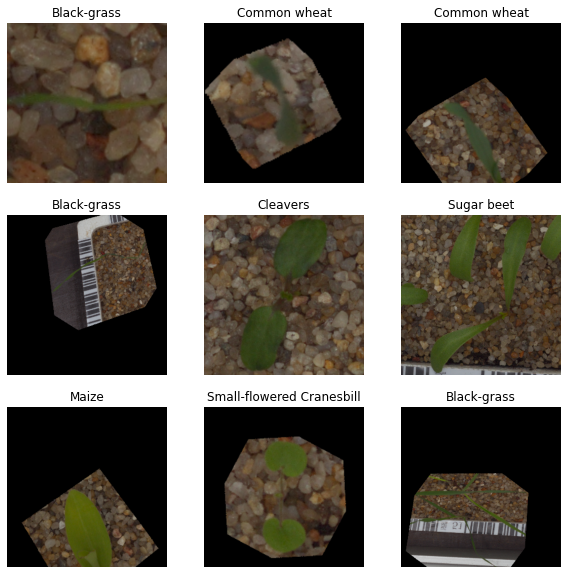

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
def input_preprocess(image, label):
    label = tf.one_hot(label, 12)
    return image, label

In [11]:
train_ds = train_ds.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)

#val_ds = val_ds.map(input_preprocess)

In [12]:
strategy = tf.distribute.MirroredStrategy()

In [13]:
from tensorflow.keras.applications import EfficientNetB2


def build_model(num_classes):
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = inputs
    model = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(0.3, name = 'drop2')(x)
    x = layers.Dense(100, activation = "relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(0.2, name = 'drop1')(x)
    x = layers.Dense(50, activation = "relu")(x)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [14]:
with strategy.scope():
    model = build_model(num_classes=num_classes)

model.summary()

31801344/31790344 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
______________________

In [15]:
epochs = 30  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, epochs=epochs, verbose=2)
model.save('large_unseg_freeze_30_1e2')

2022-03-18 05:50:58.545752: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/30


2022-03-18 05:51:10.505402: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


375/375 - 133s - loss: 1.1896 - accuracy: 0.5767
Epoch 2/30
375/375 - 87s - loss: 0.8589 - accuracy: 0.6958
Epoch 3/30
375/375 - 88s - loss: 0.7850 - accuracy: 0.7226
Epoch 4/30
375/375 - 87s - loss: 0.7423 - accuracy: 0.7347
Epoch 5/30
375/375 - 87s - loss: 0.7178 - accuracy: 0.7458
Epoch 6/30
375/375 - 86s - loss: 0.6960 - accuracy: 0.7526
Epoch 7/30
375/375 - 86s - loss: 0.6823 - accuracy: 0.7614
Epoch 8/30
375/375 - 87s - loss: 0.6523 - accuracy: 0.7717
Epoch 9/30
375/375 - 86s - loss: 0.6198 - accuracy: 0.7763
Epoch 10/30
375/375 - 87s - loss: 0.6240 - accuracy: 0.7820
Epoch 11/30
375/375 - 87s - loss: 0.6287 - accuracy: 0.7805
Epoch 12/30
375/375 - 87s - loss: 0.5930 - accuracy: 0.7900
Epoch 13/30
375/375 - 85s - loss: 0.5981 - accuracy: 0.7883
Epoch 14/30
375/375 - 87s - loss: 0.5843 - accuracy: 0.7942
Epoch 15/30
375/375 - 87s - loss: 0.5762 - accuracy: 0.7969
Epoch 16/30
375/375 - 89s - loss: 0.5819 - accuracy: 0.7937
Epoch 17/30
375/375 - 91s - loss: 0.5652 - accuracy: 0.7989

2022-03-18 06:50:09.439713: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


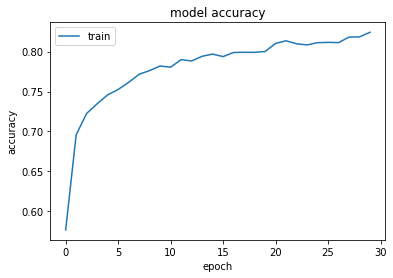

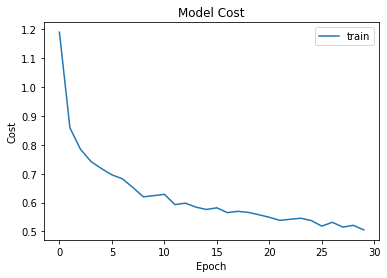

In [16]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    plt.plot(hist.history['loss'], label='train')
    # plt.plot(result.history['val_loss'], label='test')
    plt.legend(loc='upper right')
    plt.title('Model Cost')
    plt.ylabel('Cost')
    plt.xlabel('Epoch')
    plt.show()

plot_hist(hist)

In [17]:
def unfreeze_model(model):
    # We unfreeze the top 35 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-35:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

2022-03-18 06:50:37.446423: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/30
375/375 - 98s - loss: 0.4429 - accuracy: 0.8408
Epoch 2/30
375/375 - 87s - loss: 0.3634 - accuracy: 0.8749
Epoch 3/30
375/375 - 88s - loss: 0.3217 - accuracy: 0.8870
Epoch 4/30
375/375 - 88s - loss: 0.2865 - accuracy: 0.9020
Epoch 5/30
375/375 - 88s - loss: 0.2700 - accuracy: 0.9080
Epoch 6/30
375/375 - 89s - loss: 0.2471 - accuracy: 0.9145
Epoch 7/30
375/375 - 87s - loss: 0.2378 - accuracy: 0.9204
Epoch 8/30
375/375 - 89s - loss: 0.2157 - accuracy: 0.9256
Epoch 9/30
375/375 - 88s - loss: 0.1964 - accuracy: 0.9347
Epoch 10/30
375/375 - 88s - loss: 0.1780 - accuracy: 0.9393
Epoch 11/30
375/375 - 90s - loss: 0.1706 - accuracy: 0.9420
Epoch 12/30
375/375 - 89s - loss: 0.1581 - accuracy: 0.9471
Epoch 13/30
375/375 - 86s - loss: 0.1571 - accuracy: 0.9473
Epoch 14/30
375/375 - 88s - loss: 0.1401 - accuracy: 0.9523
Epoch 15/30
375/375 - 87s - loss: 0.1353 - accuracy: 0.9570
Epoch 16/30
375/375 - 88s - loss: 0.1254 - accuracy: 0.9596
Epoch 17/30
375/375 - 88s - loss: 0.1232 - accura

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


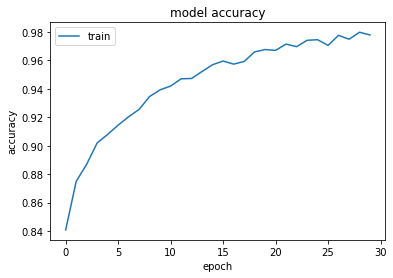

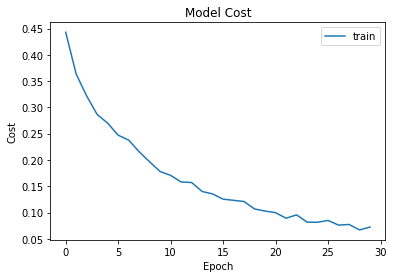

In [18]:
epochs = 30  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, verbose=2)
model.save('large_unseg_unfreeze_30_1e4')
plot_hist(hist)

2022-03-18 07:56:10.976913: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/20
375/375 - 96s - loss: 0.0694 - accuracy: 0.9778
Epoch 2/20
375/375 - 88s - loss: 0.0569 - accuracy: 0.9819
Epoch 3/20
375/375 - 88s - loss: 0.0587 - accuracy: 0.9818
Epoch 4/20
375/375 - 88s - loss: 0.0557 - accuracy: 0.9822
Epoch 5/20
375/375 - 86s - loss: 0.0490 - accuracy: 0.9854
Epoch 6/20
375/375 - 88s - loss: 0.0496 - accuracy: 0.9847
Epoch 7/20
375/375 - 89s - loss: 0.0546 - accuracy: 0.9844
Epoch 8/20
375/375 - 89s - loss: 0.0503 - accuracy: 0.9853
Epoch 9/20
375/375 - 85s - loss: 0.0457 - accuracy: 0.9863
Epoch 10/20
375/375 - 89s - loss: 0.0435 - accuracy: 0.9869
Epoch 11/20
375/375 - 89s - loss: 0.0481 - accuracy: 0.9851
Epoch 12/20
375/375 - 88s - loss: 0.0508 - accuracy: 0.9838
Epoch 13/20
375/375 - 87s - loss: 0.0453 - accuracy: 0.9861
Epoch 14/20
375/375 - 87s - loss: 0.0461 - accuracy: 0.9857
Epoch 15/20
375/375 - 88s - loss: 0.0455 - accuracy: 0.9859
Epoch 16/20
375/375 - 88s - loss: 0.0447 - accuracy: 0.9856
Epoch 17/20
375/375 - 87s - loss: 0.0467 - accura

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


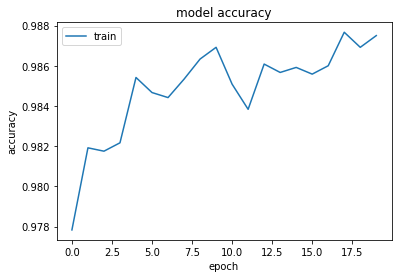

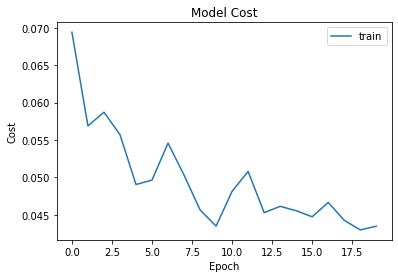

2022-03-18 08:37:59.138691: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}



Epoch 1/10
375/375 - 99s - loss: 0.0433 - accuracy: 0.9876
Epoch 2/10
375/375 - 86s - loss: 0.0422 - accuracy: 0.9862
Epoch 3/10
375/375 - 87s - loss: 0.0433 - accuracy: 0.9873
Epoch 4/10
375/375 - 89s - loss: 0.0415 - accuracy: 0.9879
Epoch 5/10
375/375 - 89s - loss: 0.0412 - accuracy: 0.9869
Epoch 6/10
375/375 - 86s - loss: 0.0434 - accuracy: 0.9867
Epoch 7/10
375/375 - 87s - loss: 0.0449 - accuracy: 0.9874
Epoch 8/10
375/375 - 88s - loss: 0.0441 - accuracy: 0.9865
Epoch 9/10
375/375 - 89s - loss: 0.0401 - accuracy: 0.9884
Epoch 10/10
375/375 - 88s - loss: 0.0386 - accuracy: 0.9881


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


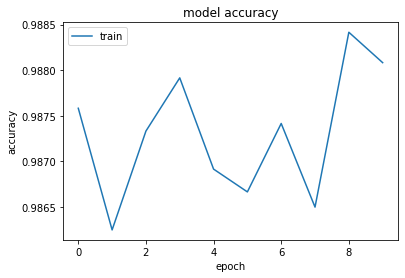

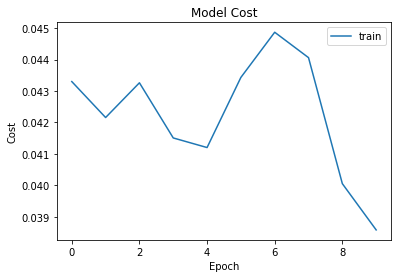

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

epochs = 20  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, verbose=2)
model.save('large_unseg_large_unseg_unfreeze_20_1e5')
plot_hist(hist)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, verbose=2)
model.save('large_unseg_unfreeze_10_1e6')
plot_hist(hist)

In [20]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
print(test.head(2))
test.shape

NameError: name 'test_dir' is not defined

In [ ]:
from tqdm import tqdm

x_test = np.zeros((len(test), img_height, img_width, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = keras.preprocessing.image.load_img(os.path.join(data_dir, filepath), target_size = (img_height, img_width))
    x = keras.preprocessing.image.img_to_array(img)
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

In [ ]:
one_hot_prediction = model.predict(x_test)
one_hot_prediction[0:2]

In [ ]:
preds = np.argmax(one_hot_prediction, axis=1)
print(preds.shape)
print(preds)
prediction = [class_names[i] for i in preds]
print(len(prediction))
print(prediction)

In [ ]:
sample_submission.head(5)

In [ ]:
my_submission = pd.DataFrame({'file': test['file'], 'species': prediction})
print(my_submission.head(5))
print(my_submission.shape)

In [ ]:
my_submission.to_csv('output.csv', index=False)